## It's all about processes

In [1]:
import numpy as np
from tqdm import tqdm
import time
import re
from collections import Counter
import nltk
from copy import deepcopy
import random
import re
import pandas as pd

In [2]:
def tsvReader(filepath):
    '''read in .tsv files, and leave the sentence ID'''
    df = pd.read_csv(filepath, sep="\t")
    # assert sum(sum(pd.isnull(df.values))) == 0     # There's no missing value
    return df[['PhraseId','Phrase','Sentiment']] # 只保留phrase ID，句子，label

In [3]:
filename = "./data/train.tsv"

dataset = tsvReader(filename)

In [4]:
print(len(dataset))
dataset.head()

156060


,PhraseId,Phrase,Sentiment
0,1,A series of escapades demonstrating the adage ...,1
1,2,A series of escapades demonstrating the adage ...,2
2,3,A series,2
3,4,A,2
4,5,series,2


In [5]:
dataset.head()
print(dataset['Sentiment'].value_counts())

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


In [51]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
            gsp.strip_tags,
            gsp.strip_punctuation,
            gsp.strip_multiple_whitespaces,
            gsp.remove_stopwords,   
            gsp.strip_short,
            gsp.stem_text
        ]

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = utils.to_unicode(sentence)
    for func in filters:
        sentence = func(sentence)
    return sentence

In [52]:
dataset['clean_sentence'] = dataset['Phrase'].apply(clean_text)

In [53]:
print(dataset.iloc[1,3])
dataset.head()

seri escapad demonstr adag good goos


,PhraseId,Phrase,Sentiment,clean_sentence
0,1,A series of escapades demonstrating the adage ...,1,seri escapad demonstr adag good goos good gand...
1,2,A series of escapades demonstrating the adage ...,2,seri escapad demonstr adag good goos
2,3,A series,2,seri
3,4,A,2,
4,5,series,2,seri


**Below are analysis borrowed from another kaggle kernel**

As was mentioned in the original competition description, there are no individual movie reviews but rather phrases taken out of context and split into smaller parts, each with an assigned sentiment category. The competition is evaluated based on scoring results of each test phrase, so the context of the whole review does not matter here. The data is also fairly clean, so there will not be need for much pre-processing. 

Before proceeding it is also a good idea to look at distribution of data, to see if the classes in training set are evenly distributed. For that I borrowed code from another github user:

<AxesSubplot: >

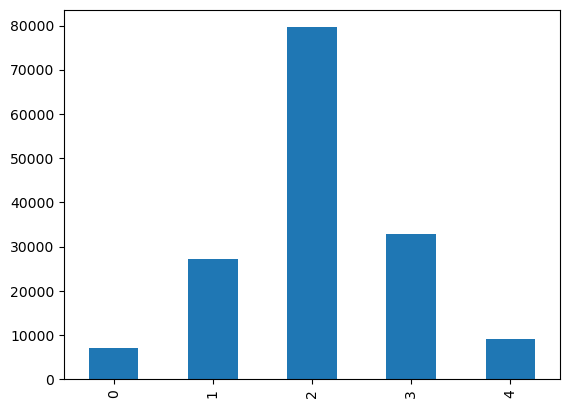

In [9]:
dataset['Sentiment'].value_counts().sort_index().plot(kind='bar')

Classes seem to follow a normal distribution, with most frequently distributed class being "2". This could lead to model not having sufficient data to learn the less-represented classes. This is something to be aware of when evaluating the model.

In [54]:
# splitting the dataset into Training, Developing and Testing Data

def train_dev_test_spliter(data_len, train_propor):   
    '''split data into train: development: test = 8:1:1 '''
    samind1 = set(random.sample(range(data_len), int(data_len*train_propor)))
    samind0 = set(range(data_len)) - samind1
    samind2 = set(random.sample(samind0, int(len(samind0) * 0.5)))
    samind3 = samind0 - samind2
    return list(samind1), list(samind2), list(samind3)
    
def spliter(data, index):
    '''split data into train: development: test = len of index[0]:index[1]:index[2]'''
    return data.iloc[index[0]], data.iloc[index[1]], data.iloc[index[2]]


In [55]:
index = train_dev_test_spliter(len(dataset),0.99)

train_text, dev_text, test_text = spliter(dataset['clean_sentence'], index)
train_label, dev_label, test_label = spliter(dataset['Sentiment'], index)

print(len(train_text), len(dev_text), len(test_text))


154499 780 781


### Use built-in functions


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [47]:
countVector = CountVectorizer(binary=True, min_df=2) 
# countVector = CountVectorizer(binary=True, max_df=0.95) 
countVector.fit_transform(train_text.to_list())   
trainFeatureSet = countVector.transform(train_text.to_list())
testFeatureSet = countVector.transform(test_text.to_list())


In [178]:
# feature scaling; Not really good performance
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean=False)
sc.fit(trainFeatureSet) 
trainFeatureSet = sc.transform(trainFeatureSet)
testFeatureSet = sc.transform(testFeatureSet)


In [49]:
logRegModel = LogisticRegression()
logRegModel.fit(trainFeatureSet, train_label)

c:\Users\equee\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [50]:
predLogReg1 = logRegModel.predict(testFeatureSet)
score = logRegModel.score(testFeatureSet, test_label)
print("Approximate Accuracy with countVectorizer : ", score*100)

Approximate Accuracy with countVectorizer :  63.07830321671152


#### Use Tf-idf

In [165]:
tfidVector = TfidfVectorizer(min_df=2, norm='l2', smooth_idf=True, use_idf=True)

tfidTrainFeatures = tfidVector.fit_transform(train_text)
tfidTestFeatures = tfidVector.transform(test_text)

In [166]:
# feature scaling; Not really good performance
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean=False)
sc.fit(trainFeatureSet) 
trainFeatureSet = sc.transform(trainFeatureSet)
testFeatureSet = sc.transform(testFeatureSet)


In [167]:
logRegModel2 = LogisticRegression()
logRegModel2.fit(tfidTrainFeatures, train_label)

c:\Users\equee\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [168]:
predLogReg2 = logRegModel2.predict(tfidTestFeatures)
score2 = logRegModel2.score(tfidTestFeatures, test_label)
print("Approximate Accuracy with Tfidf : ", score2*100)

Approximate Accuracy with Tfidf :  62.546456491093174


### Use self-defined functions

In [56]:
# Extracting features by counting word counts...
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from collections import Counter
from collections import defaultdict


In [57]:
from sklearn.utils import _IS_32BIT
import array
import numbers
from collections.abc import Mapping
from functools import partial      
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

def _document_frequency(X):
    '''count the number of non-zero values for each feature in sparse X'''
    if sp.isspmatrix_csr(X):
        return np.bincount(X.indices, minlength=X.shape[1])
    else:
        return np.diff(X.indptr) 

def _make_int_array():
    '''construct an array.array of a type suitable for scipy.sparse indice'''
    return array.array(str('i'))

def _analyze(doc, analyzer=None, tokenizer=None, ngrams=None, preprocessor=None, decoder=None, stop_words=None):
    '''chain together an optional series of text preprocessing steps to go from a single document to ngrams'''
    if decoder is not None:
        doc = decoder(doc)

    if analyzer is not None:
        doc = analyzer(doc)
    
    else:
        if preprocessor is not None:
            doc = preprocessor(doc)
        if tokenizer is not None:
            doc = tokenizer(doc)
        if ngrams is not None:
            if stop_words is not None:
                doc = ngrams(doc, stop_words)
            else:
                doc = ngrams(doc)

    return doc

def _preprocess(doc, accent_function=None, lower=False):
    '''chian together an optional series of text preprocessing steps to apply to a document'''
    if lower:
        doc = doc.lower()
    if accent_function is not None:
        doc = accent_function(doc)
    return doc

########### 用except this函数们得到准确率50% ###########
def _check_stop_list(stop):
    if stop == 'english':
        return ENGLISH_STOP_WORDS
    elif isinstance(stop, str):
        raise ValueError("not a built-in stop list: %s" % stop)
    elif stop is None:
        return None
    else: # assume it's a collection
        return frozenset(stop)    
########### 用except this函数们得到准确率50% ###########

class CountVector():
    def __init__(self, *, input='content', encoding='utf-8',
                 decode_error='strict', strip_accents=None,
                 lowercase=True, preprocessor=None, tokenizer=None,
                 stop_words=None, token_pattern=r'(?u)\b\w\w+\b',
                 ngram_range=(1,1), analyzer='word',
                 max_df=1.0, min_df=1, max_features=None,
                 vocabulary=None, binary=False, dtype=np.int64
                 ):
        self.input = input
        self.encoding = encoding
        self.strip_accents = decode_error
        self.preprocessor = preprocessor
        self.tokenizer = tokenizer
        self.analyzer = analyzer
        self.lowercase = lowercase
        self.token_pattern = token_pattern
        self.stop_words = stop_words
        self.max_df = max_df
        self.min_df = min_df
        if max_df < 0 or min_df < 0:
            raise ValueError("negative value for max_df or min_df")
        self.max_features = max_features
        if max_features is not None:
            if (not isinstance(max_features, numbers.Integral) or max_features <=0):
                raise ValueError('max_features=%r, neigher a positive integer nor None' % max_features)
        self.ngram_range = ngram_range
        self.vocabulary = vocabulary
        self.binary = binary
        self.dtype = dtype

    def _sort_features(self, X, vocabulary):
        '''sort features by name; returns a recorded matrix and modifies the vocab in place'''
        sorted_features = sorted(vocabulary.items())
        map_index = np.empty(len(sorted_features), dtype=X.indices.dtype)
        for new_val, (term, old_val) in enumerate(sorted_features):
            vocabulary[term] = new_val
            map_index[old_val] = new_val
        
        X.indices = map_index.take(X.indices, mode='clip')
        return X
    
    def _limit_features(self, X, vocabulary, high=None, low=None, limit=None):
        '''remove too rare or too common features'''
        if high is None and low is None and limit is None:
            return X, set()

        # calculate a mask based on document frequencies
        dfs = _document_frequency(X)
        mask = np.ones(len(dfs), dtype=bool)
        if high is not None:
            mask &= dfs <= high  
        if low is not None:
            mask &= dfs >= low
        if limit is not None and mask.sum() > limit:
            tfs = np.asarray(X.sum(axis=0)).ravel() 
            mask_inds = (-tfs[mask]).argsort()[:limit]
            new_mask = np.zeros(len(dfs), dtype=bool)
            new_mask[np.where(mask)[0][mask_inds]] = True
            mask = new_mask

        new_indices = np.cumsum(mask) - 1       # maps old indices to new
        removed_terms = set()
        for term, old_index in list(vocabulary.items()):
            if mask[old_index]:
                vocabulary[term] = new_indices[old_index]
            else:
                del vocabulary[term]
                removed_terms.add(term)
        kept_indices = np.where(mask)[0]
        if len(kept_indices) == 0:
            raise ValueError("after pruning, no terms remain. Try a lower min_df or a hight max_df.")

        return X[:,kept_indices], removed_terms

    def _count_vocab(self, raw_documents, fixed_vocab):
        '''create sparse feature matrix, and vocabulary where fixed_vocab=False'''
        if fixed_vocab:
            vocabulary = self.vocabulary_
        else:
            vocabulary = defaultdict()
            vocabulary.default_factory = vocabulary.__len__
        
        analyze = self.build_analyzer()
        j_indices = []
        indptr = []

        values = _make_int_array()
        indptr.append(0)
        for doc in raw_documents:
            feature_counter = {}
            for feature in analyze(doc):      
                try:
                    feature_idx = vocabulary[feature]
                    if feature_idx not in feature_counter:
                        feature_counter[feature_idx] = 1
                    else:
                        feature_counter[feature_idx] += 1
                except KeyError:
                    # NOTE: Ignore out-of-vocabulary items for fixed_vocab=True
                    continue
            
            j_indices.extend(feature_counter.keys())
            values.extend(feature_counter.values())
            indptr.append(len(j_indices))

        if not fixed_vocab:
            vocabulary = dict(vocabulary)
            if not vocabulary:
                raise ValueError("empty vocabulary; perhaps the documents contain stop words")

        if indptr[-1] > np.iinfo(np.int32).max:     # 2**31-1
            if _IS_32BIT:
                raise ValueError(('sparse CSR array has {} non-zero elements and requires 64 bit indexing, which is unsupported with 32 bit Python'.format(indptr[-1])))
            indices_dtype = np.int64
            
            
        else:
            indices_dtype = np.int32
        j_indices = np.asarray(j_indices, dtype = indices_dtype)
        indptr = np.asarray(indptr, dtype=indices_dtype)
        values = np.frombuffer(values, dtype=np.intc)

        X = sp.csr_matrix((values, j_indices, indptr), shape=(len(indptr) - 1, len(vocabulary)),
                            dtype=self.dtype)
        X.sort_indices()
        return vocabulary, X

    # def _check_vocabulary(self):
    #     '''check if vocabulary is empty or missing'''
    #     if not hasattr(self, 'vocabulary_'):
    #         self._validate_vocabulary()
    #         if not self.fixed_vocabulary_:
    #             raise ValueError   
        
    #     if len(self.vocabulary_) == 0:
    #         raise ValueError

    
    def _validate_vocabulary(self):
        '''check if vocabulary is empty or missing'''
        vocabulary = self.vocabulary
        if vocabulary is not None:
            if isinstance(vocabulary, set):
                vocabulary = sorted(vocabulary)
            if not isinstance(vocabulary, Mapping):
                vocab = {}
                for i, t in enumerate(vocabulary):
                    if vocab.setdefault(t,i) != i:
                        msg = "Duplicate term in vocabulary: %r" % t
                        raise ValueError(msg)
                vocabulary = vocab
            else:
                indices = set(vocabulary.values())
                if len(indices) != len(vocabulary):
                    raise ValueError
                for i in range(len(vocabulary)):
                    if i not in indices:
                        msg = '...'
                        raise ValueError(msg)
            
            if not vocabulary:
                raise ValueError
            self.fixed_vocabulary_ = True
            self.vocabulary_ = dict(vocabulary)
        else:
            self.fixed_vocabulary_ = False
        
    def _validate_params(self):
        '''check validity of ngram_range parameter'''
        min_n, max_m = self.ngram_range
        if min_n > max_m:
            raise ValueError
        
    def build_analyzer(self):
        '''return a callable that handles preprocessing, tokenization and n-grams generation'''
        if callable(self.analyzer):
            return partial(_analyze, analyzer=self.analyzer, decoder=self.decode)
        
        preprocess = self.build_preprocessor()

        if self.analyzer == 'word':
            stop_words = self.get_stop_words()
            tokenize = self.build_tokenizer()
            self._check_stop_words_consistency(stop_words, preprocess, tokenize)
            return partial(_analyze, ngrams=self._word_ngrams, tokenizer=tokenize, preprocessor=preprocess, decoder=self.decode, stop_words=stop_words)
        
        else:
            raise ValueError('%s is not a valid tokenization scheme/analyzer' %
                             self.analyzer)

    
    def build_preprocessor(self):
        '''return a function to prerpocess the text before tokenization'''
        if self.preprocessor is not None:
            return self.preprocessor
        
        # accent stripping
        strip_accents = None

        return partial(_preprocess, accent_function = strip_accents, lower=self.lowercase)

    def _word_ngrams(self, tokens, stop_words=None):
        if stop_words is not None:
            tokens = [w for w in tokens if w not in stop_words]

        # handle token n-grams
        min_n, max_n = self.ngram_range
        if max_n != 1:
            original_tokens = tokens
            if min_n == 1:
                tokens = list(original_tokens)
                min_n += 1
            else:
                tokens = []

            n_original_tokens = len(original_tokens)

            # bind method outside of loop to reduce overhead
            tokens_append = tokens.append
            space_join = " ".join

            for n in range(min_n, min(max_n + 1, n_original_tokens + 1)):
                for i in range(n_original_tokens - n + 1):
                    tokens_append(space_join(original_tokens[i:i + 1]))
                
        return tokens

    def decode(self, doc):
        '''decode the input into a tring of unicode symbols'''
        if self.input == 'filename':
            with open(doc, 'rb') as fh:
                doc = fh.read()
            
        elif self.input == 'file':
            doc = doc.read()

        if isinstance(doc, bytes):
            doc = doc.decode(self.encoding, self.decode_error)
        
        if doc is np.nan:
            raise ValueError("np.nan is an invalid document, expected byte or "
                             "unicode string.")
                             
        return doc

    ########### 上述函数得到的结果表现为51.5% ###########
    ########### 加上sklearn自己的stopword，tokenizer表现为63% ###########

    def build_tokenizer(self):
        '''turn a function that splits a string into a sequence of tokens'''
        if self.tokenizer is not None:
            return self.tokenizer
        token_pattern = re.compile(self.token_pattern)

        if token_pattern.groups > 1:
            raise ValueError("More than 1 capturing group in token pattern. Only a single "
                "group should be captured.")

        return token_pattern.findall

    def get_stop_words(self):
        '''build or fetch the effective stop words list'''
        return _check_stop_list(self.stop_words)

    def _check_stop_words_consistency(self, stop_words, preprocess, tokenize):
        '''check if stop words are consistent'''
        if id(self.stop_words) == getattr(self, '_stop_words_id', None):
            # stop words were previously valiated
            return None
        
        try:
            inconsistent = set()
            for w in stop_words or ():
                tokens = list(tokenize(preprocess(w)))
                for token in tokens:
                    if token not in stop_words:
                        inconsistent.add(token)
            self._stop_words_id = id(self.stop_words)

            if inconsistent: return not inconsistent    #
        
        except Exception:
            # Failed to check stop words consistency (e.g. because a custom preprocessor or tokenizer was used)
            self._stop_words_id = id(self.stop_words)
            return 'error'


    ########### built-in father class ###########

    def fit_transform(self, raw_documents, y=None):
        ''' learn the vocabulay dictionary and return document-term'''
        if isinstance(raw_documents, str):
            raise ValueError
        
        self._validate_params()
        self._validate_vocabulary()
        max_df = self.max_df
        min_df = self.min_df
        max_features = self.max_features

        vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
        
        if self.binary:
            X.data.fill(1)
        
        if not self.fixed_vocabulary_:
            n_doc = X.shape[0]
            max_doc_count = (max_df if isinstance(max_df, numbers.Integral) else max_df * n_doc)
            min_doc_count = (min_df if isinstance(min_df, numbers.Integral) else min_df * n_doc)
            if max_doc_count < min_doc_count:
                raise ValueError
            if max_features is not None:
                X = self._sort_features(X, vocabulary)
            X, self.stop_words_ = self._limit_features(X, vocabulary, max_doc_count, min_doc_count, max_features)
            if max_features is None:
                X = self._sort_features(X, vocabulary)
            self.vocabulary_ = vocabulary
        
        return X
    

    def transform(self, raw_documents):
        '''transform documents to document-term matrix'''
        if isinstance(raw_documents, str):
            raise ValueError

        # self._check_vocabulary()

        # use the same matrix-building strategy as fit_transform
        _, X = self._count_vocab(raw_documents, fixed_vocab=True)
        if self.binary:
            X.data.fill(1)
        return X



In [64]:
countVector = CountVector(binary=True, min_df=2)
# countVector = CountVectorizer(binary=True, max_df=0.95) 
trainFeatureSet = countVector.fit_transform(train_text.to_list())
testFeatureSet = countVector.transform(test_text.to_list())
devFeatureSet = countVector.transform(dev_text.to_list())


In [65]:

from sklearn.linear_model import LogisticRegression

logRegModel = LogisticRegression()
logRegModel.fit(trainFeatureSet, train_label)

predLogReg1 = logRegModel.predict(testFeatureSet)
score = logRegModel.score(testFeatureSet, test_label)
print("Approximate Accuracy with countVectorizer : ", score*100)

Approximate Accuracy with countVectorizer :  61.8437900128041


/home/junhao/anaconda3/envs/nlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Classifier Funcs

In [49]:
import pandas as pd
import numpy as np

classNum = 5


class AdaGrad:
	def __init__(self, num_row, num_col, eta=0.1, epsilon=1e-8):
		self.eta = eta
		self.epsilon = epsilon
		self.cache = np.zeros((num_row, num_col))

	def update(self, W, gradient):
		self.cache += gradient ** 2
		W -= self.eta / np.sqrt(self.cache + self.epsilon) * gradient
		return W


class SoftmaxRegression:
    def __init__(self):
        pass

    def softmax(self, x):
        # return np.exp(x) / np.sum(np.exp(x))
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)


    def train_bgd(self, x_train, y_train, x_dev, y_dev, batch_size=1000, max_itr=100, alpha=0.1, lamda=0, tol=1e-4):
        self.weights = np.random.uniform(0, 1, (classNum, x_train.shape[1]+1))
        optimizer = AdaGrad(num_row=x_train.shape[1]+1, num_col=classNum)
        losses = []
        # dev_x = x_dev.toarray()
        dev_x = np.hstack((x_dev.toarray(), np.ones((x_dev.shape[0],1))))
        for itr in range(max_itr):
            err = np.zeros((classNum, x_train.shape[1]+1))
            cum_err = 0
            
            for i in range(0,len(x_train.indptr)-1, batch_size):
                cur_batch_size = min(batch_size,len(x_train.indptr)-1-i)
                x = np.hstack((x_train[i:i+batch_size].toarray(), np.ones((cur_batch_size,1))))
                y = np.zeros((5,cur_batch_size))
                for j in range(cur_batch_size):
                    y[:,j][y_train.iloc[i+j]] = 1
                # h_y = self.softmax(np.dot(self.weights, x.T))
                h_y = np.apply_along_axis(self.softmax, 0, np.dot(self.weights, x.T))

                errs = np.dot((h_y - y), x)
                err = np.sum(errs, axis=1) / cur_batch_size

                regular = (alpha * lamda * self.weights) / cur_batch_size
                # self.weights = self.weights - alpha * err.reshape((-1,1)) + regular
                # self.weights = optimizer.update(self.weights.T, err.T).T
                self.weights = optimizer.update(self.weights.T, err.T + regular).T
                # self.weights = self.weights - alpha * err.reshape((-1,1))

            h_y = np.apply_along_axis(self.softmax, 0, np.dot(self.weights, dev_x.T))
            # deviation = [1 - np.log(h_y[:,j][y_dev.iloc[j]]+1e-6) for j in range(len(y_dev))]
            deviation = [1 - np.log(h_y[:,j][y_dev.iloc[j]]) for j in range(len(y_dev))]
            losses.append(np.sum(deviation) / cur_batch_size)

            if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < tol:
                print('converge! last_iter:{:d}, last loss:{:.4f}'.format(itr,losses[-1]))
                break 

            print('iter:{:d}, dev_loss:{:.4f}'.format(itr,losses[-1]))

    def predict(self, x_test):
        y_predict = []
        for i in range(len(x_test.indptr)-1):
            x = np.hstack((x_test[i].toarray(), np.ones((1,1)))).T
            y = np.argmax(np.dot(self.weights, x))
            y_predict.append(y)

        return y_predict

    def test(self, y_test, y_predict):
        print("testing...")
        accuracy = 0
        for i in range(len(y_test)):
            if y_predict[i] == y_test.iloc[i]:
                accuracy += 1

        accuracy = accuracy / len(y_test)
        print("accuracy = {:.3f}".format(accuracy))
        return accuracy



In [50]:

x_train_vec, x_test_vec, y_train, y_test = trainFeatureSet, testFeatureSet, train_label, test_label
x_dev_vec, y_dev = devFeatureSet, dev_label

sl = SoftmaxRegression()
sl.train_bgd(x_train_vec, y_train, x_dev_vec, y_dev, batch_size=10000, lamda=0.2, alpha=0.15, max_itr=30, tol=0)
y_predict = sl.predict(x_test_vec)
accuracy = sl.test(y_test, y_predict)


iter:0, dev_loss:0.5038
iter:1, dev_loss:0.5041
iter:2, dev_loss:0.5041
iter:3, dev_loss:0.5041
iter:4, dev_loss:0.5041
iter:5, dev_loss:0.5041
iter:6, dev_loss:0.5041
iter:7, dev_loss:0.5041
iter:8, dev_loss:0.5041
iter:9, dev_loss:0.5041
iter:10, dev_loss:0.5041
iter:11, dev_loss:0.5041
iter:12, dev_loss:0.5041
iter:13, dev_loss:0.5041
iter:14, dev_loss:0.5041
iter:15, dev_loss:0.5041
iter:16, dev_loss:0.5041
iter:17, dev_loss:0.5041
iter:18, dev_loss:0.5041
iter:19, dev_loss:0.5041
iter:20, dev_loss:0.5041
iter:21, dev_loss:0.5041
iter:22, dev_loss:0.5041
iter:23, dev_loss:0.5041
iter:24, dev_loss:0.5041
iter:25, dev_loss:0.5041
iter:26, dev_loss:0.5041
iter:27, dev_loss:0.5041
iter:28, dev_loss:0.5041
iter:29, dev_loss:0.5041
testing...
accuracy = 0.201


In [86]:
import pandas as pd
import numpy as np

classNum = 5

class AdaGrad:
	def __init__(self, num_row, num_col, eta=0.1, epsilon=1e-8):
		self.eta = eta
		self.epsilon = epsilon
		self.cache = np.zeros((num_row, num_col))

	def update(self, W, gradient):
		self.cache += gradient ** 2
		W -= self.eta / np.sqrt(self.cache + self.epsilon) * gradient
		return W
        
class LogisticRegression:
    def __init__(self):
        pass

    def logistic(self, x):
        temp = 1 / (1 + np.exp(-x))
        return temp / np.sum(temp)
        

    def train_bgd(self, x_train, y_train, x_dev, y_dev, batch_size=1000, max_itr=100, alpha=0.1, lamda=0, tol=1e-4):
        self.weights = np.random.uniform(0, 1, (classNum, x_train.shape[1]+1))
        optimizer = AdaGrad(num_row=x_train.shape[1]+1, num_col=classNum)
        losses = []
        dev_x = np.hstack((x_dev.toarray(), np.ones((x_dev.shape[0],1))))
        for itr in range(max_itr):
            err = np.zeros((classNum, x_train.shape[1]+1))
            cum_err = 0
            
            for i in range(0,len(x_train.indptr)-1, batch_size):
                cur_batch_size = min(batch_size,len(x_train.indptr)-1-i)
                x = np.hstack((x_train[i:i+batch_size].toarray(), np.ones((cur_batch_size,1))))
                y = np.zeros((5,cur_batch_size))
                for j in range(cur_batch_size):  y[:,j][y_train.iloc[i+j]] = 1
                h_y = np.apply_along_axis(self.logistic, 0, np.dot(self.weights, x.T))

                # MSE loss gradient
                # h_y = self.logistic(np.dot(self.weights, x.T))
                errs = np.dot((h_y - y), x)

                # Cross Entropy loss gradient
                # h_yy = np.zeros((5,cur_batch_size))
                # for j in range(cur_batch_size):  h_yy[y_train.iloc[i+j],j] = h_y[y_train.iloc[i+j],j]
                # errs = np.dot((h_yy - y), x)

                
                err = np.sum(errs, axis=1) / batch_size
                regular = (alpha * lamda * self.weights) / batch_size
                # self.weights = self.weights - alpha * err.reshape((-1,1)) + regular
                # self.weights = optimizer.update(self.weights.T, err.T + regular).T
                self.weights = optimizer.update(self.weights.T, err.T).T

            h_y = np.apply_along_axis(self.logistic, 0, np.dot(self.weights, dev_x.T))
            
            # MSE loss
            y = np.zeros((5, dev_x.shape[0]))
            for j in range(dev_x.shape[0]):  y[:,j][y_dev.iloc[j]] = 1
            losses.append(np.sum(np.power(h_y-y,2)) / dev_x.shape[0])

            # Cross-Entropy loss
            # deviation = [1 - np.log(h_y[:,j][y_dev.iloc[j]]) for j in range(len(y_dev))]
            # losses.append(np.sum(deviation) / batch_size)

            if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < tol:
                print('converge! last_iter:{:d}, last loss:{:.4f}'.format(itr,losses[-1]))
                break 

            print('iter:{:d}, dev_loss:{:.4f}'.format(itr,losses[-1]))

    def predict(self, x_test):
        y_predict = []
        for i in range(len(x_test.indptr)-1):
            x = np.hstack((x_test[i].toarray(), np.ones((1,1)))).T
            y = np.argmax(np.dot(self.weights, x))
            y_predict.append(y)

        return y_predict

    def test(self, y_test, y_predict):
        print("testing...")
        accuracy = 0
        for i in range(len(y_test)):
            if y_predict[i] == y_test.iloc[i]:
                accuracy += 1

        accuracy = accuracy / len(y_test)
        print("accuracy = {:.3f}".format(accuracy))
        return accuracy



In [89]:

x_train_vec, x_test_vec, y_train, y_test = trainFeatureSet, testFeatureSet, train_label, test_label
x_dev_vec, y_dev = devFeatureSet, dev_label

sl = LogisticRegression()
sl.train_bgd(x_train_vec, y_train, x_dev_vec, y_dev, lamda=0.2, alpha=0.1, batch_size=10000, max_itr=30, tol=0)
y_predict = sl.predict(x_test_vec)
accuracy = sl.test(y_test, y_predict)



iter:0, dev_loss:0.7222
iter:1, dev_loss:0.6970
iter:2, dev_loss:0.6887
iter:3, dev_loss:0.6869
iter:4, dev_loss:0.6863
iter:5, dev_loss:0.6860
iter:6, dev_loss:0.6860
iter:7, dev_loss:0.6860
iter:8, dev_loss:0.6860
iter:9, dev_loss:0.6860
iter:10, dev_loss:0.6860
iter:11, dev_loss:0.6861
iter:12, dev_loss:0.6861
iter:13, dev_loss:0.6861
iter:14, dev_loss:0.6861
iter:15, dev_loss:0.6861
iter:16, dev_loss:0.6862
iter:17, dev_loss:0.6862
iter:18, dev_loss:0.6862
iter:19, dev_loss:0.6862
iter:20, dev_loss:0.6862
iter:21, dev_loss:0.6862
iter:22, dev_loss:0.6863
iter:23, dev_loss:0.6863
iter:24, dev_loss:0.6863
iter:25, dev_loss:0.6863
iter:26, dev_loss:0.6863
iter:27, dev_loss:0.6863
iter:28, dev_loss:0.6863
iter:29, dev_loss:0.6863
testing...
accuracy = 0.517
